# vta: Mini-Challenge Gradient Descent

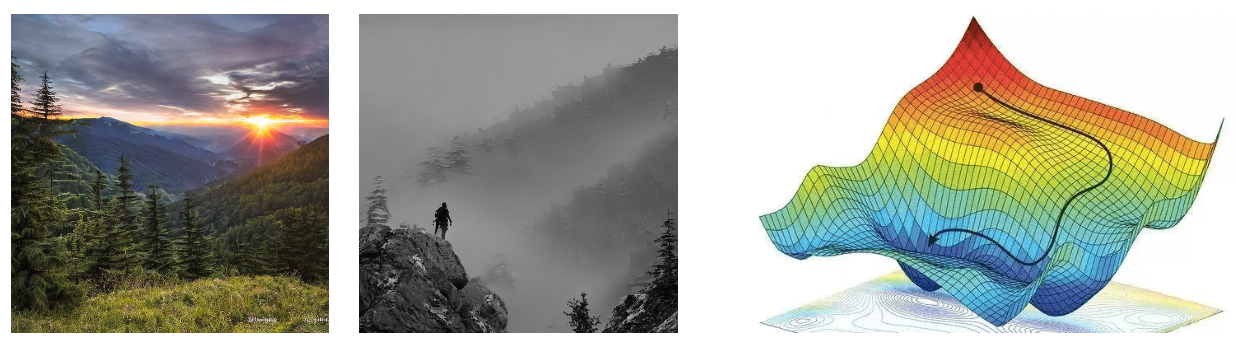

Das Ziel dieser Aufgabe besteht darin, dass Sie ein grundlegendes Verständnis für numerische Näherungsverfahren in höheren Dimensionen erlangen, insbesondere für den Gradient Descent und dessen praktische Anwendung. Hierfür sollen Sie ein Jupyter Notebook erstellen und das MNIST Dataset laden und erkunden. Anschließend sollen Sie ein neuronales Netzwerk erstellen und trainieren, um die Bilder korrekt zu klassifizieren. Es dürfen nur die angegebenen Python packages verwendet werden.

Ziel dieser Aufgabe ist nicht nur, Ihre mathematischen Kenntnisse unter Beweis zu stellen, sondern auch die entsprechende Kommunikation und Präsentation Ihrer Ergebnisse. Ihre Abgaben sollen also nicht nur mathematisch korrekt, sondern auch leicht verständlich und reproduzierbar sein. Genauere Angaben zu den Erwartungen an die Abgabe finden Sie in den Auswertungskriterien. Dokumentieren Sie ihren Arbeitsfortschritt und Erkenntnisgewinn in Form eines Lerntagebuchs, um Lernfortschritte, Schwierigkeiten und Erkenntnisse festzuhalten.
Die folgenden Aufgabenstellungen präzisieren die einzelnen Bearbeitungsschritte und geben die Struktur des Notebooks vor.

- Dominik Filliger

- Noah Leuenberger

- Nils Fahrni

- Oliver Pejic

In [1]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

/shared-libs/python3.10/py/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Aufgabe 1

> Laden Sie das MNIST-Dataset mithilfe des torchvision-Pakets (Verwenden Sie das torchvision Paket für diese Aufgabe) und verwenden Sie matplotlib, um sich einen Überblick über die Daten zu verschaffen. Beschreiben Sie das grundlegenden Eigenschaften des Datensets, z.B. wie viele und welche Daten es enthält.

In [2]:
# Define transformations to be applied to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Extract the data and labels from the datasets
X_train, y_train = train_set.data.numpy(), train_set.targets.numpy()
X_test, y_test = test_set.data.numpy(), test_set.targets.numpy()

# Reshape the data to be of size [N x 784]
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Normalize the data to be between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

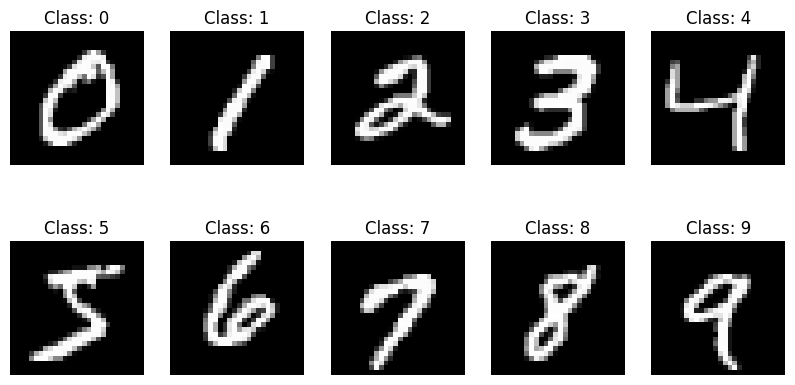

In [3]:
classes = np.unique(y_train)

# Plot the images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[y_train == classes[i]][0].reshape(28, 28), cmap='gray')
    ax.set_title(f"Class: {classes[i]}")
    ax.axis('off')

plt.show()

In [4]:
print('Number of training examples: ', X_train.shape[0])
print('Number of testing examples: ', X_test.shape[0])
print('Each image is of size: ', X_train.shape[1])
print('There are {} classes: {}'.format(len(classes), classes))
print('The data is of type: ', X_train.dtype)
print('The labels are of type: ', y_train.dtype)
print('The range of the pixel values is [{}, {}]'.format(np.min(X_train), np.max(X_train)))

Number of training examples:  60000
Number of testing examples:  10000
Each image is of size:  784
There are 10 classes: [0 1 2 3 4 5 6 7 8 9]
The data is of type:  float64
The labels are of type:  int64
The range of the pixel values is [0.0, 1.0]


## Aufgabe 2

> Erstellen Sie eine Klasse für ein lineares Layer mit beliebig vielen Knoten. Implementieren Sie die Methoden forward, backward und update mithilfe von numpy. Schreiben sie geeignete Unittests, um die Funktionsweise der Funktion zu prüfen.

### Linear Layer

In [5]:
class LinearLayer():
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.bias = np.zeros((1, output_size))

    def forward(self, x):
        self.x = x
        return np.dot(x, self.weights) + self.bias

    def backward(self, grad_output):
        self.weights_grad = np.dot(self.x.T, grad_output)
        self.bias_grad = np.sum(grad_output, axis=0, keepdims=True)
        return np.dot(grad_output, self.weights.T)

    def update(self, lr):
        self.weights -= lr * self.weights_grad
        self.bias -= lr * self.bias_grad

### Unit Testing

In [6]:
import unittest

class TestLinearLayer(unittest.TestCase):
    def setUp(self):
        self.input_size = 10
        self.output_size = 5
        self.linear_layer = LinearLayer(self.input_size, self.output_size)

    def test_forward(self):
        x = np.random.randn(1, self.input_size)
        output = self.linear_layer.forward(x)
        self.assertEqual(output.shape, (1, self.output_size))

    def test_backward(self):
        x = np.random.randn(1, self.input_size)
        output = self.linear_layer.forward(x)
        grad_output = np.random.randn(1, self.output_size)
        grad_input = self.linear_layer.backward(grad_output)
        self.assertEqual(grad_input.shape, (1, self.input_size))

unittest.main(argv=[''], verbosity=2, exit=False)

test_backward (__main__.TestLinearLayer) ... ok
test_forward (__main__.TestLinearLayer) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.002s

OK


## Aufgabe 3

> Erstellen Sie ein neuronales Netzwerk in numpy mit einem Hidden Linear Layer und einem Output Knoten. Trainieren Sie das Netzwerk darauf, die Ziffer 4 korrekt zu identifizieren (d.h. der Output soll 1 für diese Ziffer und 0 für alle anderen Ziffern sein). Trainieren Sie das Netzwerk auf den Trainingsdaten und evaluieren Sie es anhand von Testdaten. Verwenden Sie eine geeignete Loss-Funktion sowie Accuracy-Funktion und geben Sie deren mathematische Definition an. Begründen Sie Ihre Wahl mit einer Abwägung der Vor- und Nachteile. Diskutieren Sie kurz weitere Optionen für Loss und Accuracy.

### Non-Linear Activation Functions

In [7]:
# Helper functions
def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    return x > 0

def sigmoid(x):
    x = np.clip(x, -500, 500) # clip x to prevent overflow
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

### Loss Functions

In [8]:
def mse(y_pred, y_true):
    batch_size = y_pred.shape[0]
    loss = np.sum((y_pred - y_true)**2) / batch_size
    return loss

def mse_grad(y_pred, y_true):
    batch_size = y_pred.shape[0]
    grad = 2 * (y_pred - y_true) / batch_size
    return grad

def binary_cross_entropy(y_pred, y_true):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1-eps) # clip y_pred to prevent log(0) or log(1)
    loss = -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)).mean()
    return loss

def binary_cross_entropy_grad(y_pred, y_true):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1-eps) # clip y_pred to prevent division by 0
    grad = (y_pred - y_true) / (y_pred * (1 - y_pred) + eps) # add eps to prevent division by 0
    return grad

### Single-Layer Network 

In [9]:
class SingleLayerNetwork():
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.linear1 = LinearLayer(input_size, hidden_size)
        self.linear2 = LinearLayer(hidden_size, output_size)

    def forward(self, x):
        self.x = x
        self.h = relu(self.linear1.forward(x))
        self.y_pred = sigmoid(self.linear2.forward(self.h))
        return self.y_pred

    def backward(self, y_true):
        y_true = y_true.reshape(-1, 1)
        self.y_pred = self.y_pred.reshape(-1, 1)

        grad_output = binary_cross_entropy_grad(self.y_pred, y_true)

        grad_output = sigmoid_grad(grad_output) * grad_output
        grad_output = self.linear2.backward(grad_output)

        grad_output = relu_grad(grad_output) * grad_output
        grad_output = self.linear1.backward(grad_output)

        return grad_output

    def update(self, lr):
        self.linear1.update(lr)
        self.linear2.update(lr)

    def train(self, X, y, lr, epochs, batch_size, threshold=0.5):
        for epoch in range(epochs):
            loss_list = []
            for i in range(0, len(X), batch_size):
                batch = np.random.choice(len(X), batch_size)
                X_batch = X[batch]
                y_batch = y[batch]

                y_pred = self.forward(X_batch)

                loss = binary_cross_entropy(y_pred, y_batch)
                loss_list.append(loss)

                self.backward(y_batch)
                self.update(lr)

            accuracy = self.evaluate(X, y, threshold)
            loss = np.mean(loss_list)
            print(f"Epoch {epoch+1} - Loss: {loss:.4f} - Accuracy: {accuracy:.4f}")

    def predict(self, X, threshold=0.5):
        y_pred = self.forward(X)
        return (y_pred > threshold).astype(int)

    def evaluate(self, X, y, threshold=0.5):
        y_pred = self.forward(X)
        y_pred_binary = (y_pred > threshold).astype(int)
        accuracy = np.mean(y_pred_binary == y.reshape(-1, 1))
        return accuracy


### Training on digit 4

In [10]:
y_train_4_binary = (y_train == 4).astype(int)
y_test_4_binary = (y_test == 4).astype(int)

# use a train set with only 4s
X_train_4_only = X_train[y_train == 4]
y_train_4_only = y_train[y_train == 4]

y_train_4_only_binary = (y_train_4_only == 4).astype(int)

# Test 4s only
X_test_4_only = X_test[y_test == 4]
y_test_4_only = y_test[y_test == 4]

y_test_4_only_binary = (y_test_4_only == 4).astype(int)

# Not 4s
X_train_not_4 = X_train[y_train != 4]
y_train_not_4 = y_train[y_train != 4]

X_test_not_4 = X_test[y_test != 4]
y_test_not_4 = y_test[y_test != 4]

# mixed train set 50% 4s and 50% not 4s
X_train_not_4 = X_train_not_4[:len(X_train_4_only)]
y_train_not_4 = y_train_not_4[:len(y_train_4_only)]

X_test_not_4 = X_test_not_4[:len(X_test_4_only)]
y_test_not_4 = y_test_not_4[:len(y_test_4_only)]

# Train for mixed train set
X_train_mix = np.concatenate((X_train_4_only, X_train_not_4))
y_train_mix = np.concatenate((y_train_4_only, y_train_not_4))

# Test for mixed train set
X_test_mix = np.concatenate((X_test_4_only, X_test_not_4))
y_test_mix = np.concatenate((y_test_4_only, y_test_not_4))

y_train_mix_binary = (y_train_mix == 4).astype(int)
y_test_mix_binary = (y_test_mix == 4).astype(int)


# print count of 4s and not 4s in the train set
print(f"4s: {np.sum(y_train_mix_binary == 1)} - Not 4s: {np.sum(y_train_mix_binary == 0)}")


4s: 5842 - Not 4s: 5842


In [11]:
# Train the network on the mixed train set
network_single_mixed = SingleLayerNetwork(input_size=784, hidden_size=256, output_size=1)
network_single_mixed.train(X_train_mix, y_train_mix_binary, lr=0.00000001, epochs=10, batch_size=20, threshold=0.5)

Epoch 1 - Loss: 0.6931 - Accuracy: 0.4684
Epoch 2 - Loss: 0.6932 - Accuracy: 0.4685
Epoch 3 - Loss: 0.6932 - Accuracy: 0.4686
Epoch 4 - Loss: 0.6932 - Accuracy: 0.4685
Epoch 5 - Loss: 0.6932 - Accuracy: 0.4685
Epoch 6 - Loss: 0.6932 - Accuracy: 0.4687
Epoch 7 - Loss: 0.6932 - Accuracy: 0.4689
Epoch 8 - Loss: 0.6931 - Accuracy: 0.4689
Epoch 9 - Loss: 0.6932 - Accuracy: 0.4689
Epoch 10 - Loss: 0.6932 - Accuracy: 0.4689


In [12]:

# Train the network on the normal train set
network_single_normal = SingleLayerNetwork(input_size=784, hidden_size=256, output_size=1)
network_single_normal.train(X_train, y_train_4_binary, lr=0.00000001, epochs=10, batch_size=20, threshold=0.5)

Epoch 1 - Loss: 0.6940 - Accuracy: 0.4923
Epoch 2 - Loss: 0.6939 - Accuracy: 0.4986
Epoch 3 - Loss: 0.6938 - Accuracy: 0.5049
Epoch 4 - Loss: 0.6938 - Accuracy: 0.5118
Epoch 5 - Loss: 0.6937 - Accuracy: 0.5190
Epoch 6 - Loss: 0.6936 - Accuracy: 0.5256


KeyboardInterrupt: 

In [ ]:
# test 4s only
network_single_four = SingleLayerNetwork(input_size=784, hidden_size=256, output_size=1)
network_single_four.train(X_train_4_only, y_train_4_only_binary, lr=0.00000001, epochs=10, batch_size=20, threshold=0.5)

### Testing on digit 4

In [ ]:
# test the network
accuracy = network_single_normal.evaluate(X_test, y_test_4_binary, 0.5)
accuracy_4 = network_single_four.evaluate(X_test_4_only, y_test_4_only_binary, 0.5)
accuracy_mix = network_single_mixed.evaluate(X_test, y_test_mix_binary , 0.5)

print(f"Accuracy: {accuracy:.4f} - Accuracy 4s only: {accuracy_4:.4f} - Accuracy mixed: {accuracy_mix:.4f}")

# maybe training more different sets helps

network_single_all = SingleLayerNetwork(input_size=784, hidden_size=256, output_size=1)
network_single_all.train(X_train_mix, y_train_mix_binary, lr=0.00000001, epochs=10, batch_size=20, threshold=0.5)
network_single_all.train(X_test, y_train_4_binary, lr=0.00000001, epochs=10, batch_size=20, threshold=0.5)


accuracy_all = network_single_all.evaluate(X_test, y_test_4_binary, 0.5)
accuracy_all_4 = network_single_all.evaluate(X_test_4_only, y_test_4_only_binary, 0.5)
accuracy_all_mix = network_single_all.evaluate(X_test, y_test_mix_binary , 0.5)

print(f"Accuracy: {accuracy_all:.4f} - Accuracy 4s only: {accuracy_all_4:.4f} - Accuracy mixed: {accuracy_all_mix:.4f}")

## Aufgabe 4

> Trainieren Sie das Netzwerk mit verschiedenen Lernraten und Größen des Hidden Layers. Verfolgen Sie während des Trainings die Entwicklung der Loss- und Accuracy-Funktionen auf Trainings- und Testdatensätzen und entscheiden Sie, welche Wahl von Lernrate und Hidden Layer-Größe die besten Ergebnisse in geringster Zeit liefert.

### Finding the right hyperparameters

In [16]:
# BRUTE FORCE TESTING FOR IDEAL SETTINGS
import time
epochs = [10, 20, 50, 100]
batch_sizes = [32, 64, 128, 256, 512]
learning_rates = [10**-i for i in range(1, 8)]
hidden_sizes = [32, 64, 128, 256, 512]

combinations = [(e, b, l, h) for e in epochs for b in batch_sizes for l in learning_rates for h in hidden_sizes]
results = [(0, 0, 0, 0, 0, 0, 0)]

for e, b, l, h in combinations:
    network = SingleLayerNetwork(input_size=784, hidden_size=h, output_size=1)

    start = time.time()
    network.train(X_train, y_train_4_binary, lr=l, epochs=e, batch_size=b)

    accuracy = network.evaluate(X_test, y_test_4_binary)
    accuracy_4 = network.evaluate(X_test_4_only, y_test_4_only_binary)

    network_mix = SingleLayerNetwork(input_size=784, hidden_size=h, output_size=1)
    network_mix.train(X_train_mix, y_train_mix_binary, lr=l, epochs=e, batch_size=b)

    accuracy_mix = network_mix.evaluate(X_test, y_test_4_binary)
    accuracy_mix_4 = network_mix.evaluate(X_test_4_only, y_test_4_only_binary)

    end = time.time()

    # save the results
    if (accuracy * 0.5 + accuracy_4 * 0.5) > (results[-1][5] + results[-1][4]):
        results.append((e, b, l, h, accuracy, accuracy_4, end-start))
        print(f"Epochs: {e} - Batch size: {b} - Learning rate: {l} - Hidden size: {h} - Accuracy: {accuracy:.4f} - Accuracy_4: {accuracy_4:.4f}")
    
print(results[-1])

Epoch 1 - Loss: 3.2694 - Accuracy: 0.9026
Epoch 2 - Loss: 3.3497 - Accuracy: 0.9026
Epoch 3 - Loss: 3.3416 - Accuracy: 0.9026
Epoch 4 - Loss: 3.3416 - Accuracy: 0.9026
Epoch 5 - Loss: 3.2754 - Accuracy: 0.9026
Epoch 6 - Loss: 3.3198 - Accuracy: 0.9026
Epoch 7 - Loss: 3.3531 - Accuracy: 0.9026
Epoch 8 - Loss: 3.3802 - Accuracy: 0.9026
Epoch 9 - Loss: 3.3405 - Accuracy: 0.9026
Epoch 10 - Loss: 3.3911 - Accuracy: 0.9026
Epochs: 10 - Batch size: 32 - Learning rate: 0.1 - Hidden size: 32 - Accuracy: 0.9018 - Accuracy_4: 0.0000
Epoch 1 - Loss: 3.3014 - Accuracy: 0.9026
Epoch 2 - Loss: 3.3635 - Accuracy: 0.9026
Epoch 3 - Loss: 3.3249 - Accuracy: 0.9026
Epoch 4 - Loss: 3.3393 - Accuracy: 0.9026
Epoch 5 - Loss: 3.3813 - Accuracy: 0.9026
Epoch 6 - Loss: 3.3647 - Accuracy: 0.9026
Epoch 7 - Loss: 3.3566 - Accuracy: 0.9026
Epoch 8 - Loss: 3.3969 - Accuracy: 0.9026
Epoch 9 - Loss: 3.3618 - Accuracy: 0.9026
Epoch 10 - Loss: 3.4251 - Accuracy: 0.9026
Epoch 1 - Loss: 3.3408 - Accuracy: 0.9026
Epoch 2 -

KeyboardInterrupt: 

## Aufgabe 5

> Erweitern Sie das Netzwerk auf 3 Hidden Layer mit gleicher Größe und 10 Outputs. Das Ziel ist die korrekte Klassifizierung aller Ziffern. Verwenden Sie eine geeignete Loss-Funktion sowie Accuracy-Funktion und geben Sie deren mathematische Definition an. Begründen Sie Ihre Wahl und diskutieren Sie kurz weitere Möglichkeiten. Variieren Sie die Lernrate und die Größe der Hidden Layer und wählen Sie das beste Ergebnis aus.

### Activation Functions

In [ ]:
def cross_entropy(y_pred, y_true):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1-eps) # clip y_pred to prevent log(0) or log(1)
    loss = -(y_true * np.log(y_pred)).sum(axis=1).mean()
    return loss

def cross_entropy_grad(y_pred, y_true):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1-eps) # clip y_pred to prevent division by 0
    grad = y_pred - y_true
    return grad

def softmax(x):
    x = x - np.max(x, axis=1, keepdims=True) # prevent overflow
    x = np.exp(x)
    x = x / np.sum(x, axis=1, keepdims=True)
    return x

def softmax_grad(x):
    return softmax(x) * (1 - softmax(x))

### Gradient of the Cross-Entropy loss function
The reason why the `cross_entropy_grad` function uses the difference between the predicted probabilities and the true labels, instead of the negative of the gradient of the cross-entropy loss with respect to the predicted probabilities, is that they are equivalent up to a constant factor.

Let's first consider the gradient of the cross-entropy loss with respect to the predicted logits, denoted as $\mathbf{z}$. The logits are related to the predicted probabilities via the softmax function:

$$
y_{i} = \frac{e^{z_{i}}}{\sum_{j} e^{z_{j}}}
$$

Taking the partial derivative of $\mathcal{L}$ with respect to $z_{j}$, we have:

$$
\frac{\partial \mathcal{L}}{\partial z_{j}} = \sum_{i} \frac{\partial \mathcal{L}}{\partial y_{i}} \frac{\partial y_{i}}{\partial z_{j}}
$$

Using the chain rule, we have:

$$
\frac{\partial y_{i}}{\partial z_{j}} = y_{i} (\delta_{ij} - y_{j})
$$

where $\delta_{ij}$ is the Kronecker delta function that is equal to 1 if $i = j$ and 0 otherwise. Substituting this expression into the above equation, we obtain:

$$
\frac{\partial \mathcal{L}}{\partial z_{j}} = \sum_{i} (\delta_{ij} - y_{j}) t_{i}
$$

This expression is equivalent to the difference between the predicted probabilities and the true labels. To see this, note that the predicted probabilities can be written as:

$$
y_{j} = \frac{e^{z_{j}}}{\sum_{k} e^{z_{k}}}
$$

Taking the derivative of $y_{j}$ with respect to $z_{j}$, we have:

$$
\frac{\partial y_{j}}{\partial z_{j}} = y_{j} (1 - y_{j})
$$

Substituting this expression into the gradient expression, we obtain:

$$
\frac{\partial \mathcal{L}}{\partial z_{j}} = y_{j} - t_{j}
$$

which is the difference between the predicted probabilities and the true labels. Thus, the `cross_entropy_grad` function is equivalent to the negative of the gradient of the cross-entropy loss with respect to the predicted probabilities, up to a constant factor.



### One-Hot Encoding

In [ ]:
def one_hot_encode(y):
    y_one_hot = np.zeros((len(y), 10))
    y_one_hot[np.arange(len(y)), y] = 1
    return y_one_hot

### Multi-Layer Network

In [ ]:
class MultiLayerNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.input_layer = LinearLayer(input_size, hidden_size)
        self.hidden_layer1 = LinearLayer(hidden_size, hidden_size)
        self.hidden_layer2 = LinearLayer(hidden_size, hidden_size)
        self.output_layer = LinearLayer(hidden_size, output_size)

    def forward(self, x):
        self.input_data = x
        self.hidden_output1 = relu(self.input_layer.forward(x))
        self.hidden_output2 = relu(self.hidden_layer1.forward(self.hidden_output1))
        self.hidden_output3 = relu(self.hidden_layer2.forward(self.hidden_output2))
        self.predicted_output = softmax(self.output_layer.forward(self.hidden_output3))
        return self.predicted_output

    def backward(self, y_true):
        gradient_output = cross_entropy_grad(self.predicted_output, y_true)

        gradient_output = softmax_grad(self.predicted_output) * gradient_output
        gradient_output = self.output_layer.backward(gradient_output)

        gradient_output = relu_grad(self.hidden_output3) * gradient_output
        gradient_output = self.hidden_layer2.backward(gradient_output)

        gradient_output = relu_grad(self.hidden_output2) * gradient_output
        gradient_output = self.hidden_layer1.backward(gradient_output)

        gradient_output = relu_grad(self.hidden_output1) * gradient_output
        gradient_output = self.input_layer.backward(gradient_output)

        return gradient_output

    def update(self, learning_rate):
        self.input_layer.update(learning_rate)
        self.hidden_layer1.update(learning_rate)
        self.hidden_layer2.update(learning_rate)
        self.output_layer.update(learning_rate)

    def train(self, X, y, learning_rate, epochs, batch_size):
        for epoch in range(epochs):
            loss_list = []
            for i in range(0, len(X), batch_size):
                batch_indices = np.random.choice(len(X), batch_size)
                X_batch = X[batch_indices]
                y_batch = y[batch_indices]

                predicted_output = self.forward(X_batch)

                loss = cross_entropy(predicted_output, y_batch)
                loss_list.append(loss)

                self.backward(y_batch)
                self.update(learning_rate)

            accuracy = self.evaluate(X, y)
            average_loss = np.mean(loss_list)
            print(f"Epoch {epoch+1} - Loss: {average_loss:.4f} - Accuracy: {accuracy:.4f}")

    def predict(self, X):
        predicted_output = self.forward(X)
        return np.argmax(predicted_output, axis=1)

    def evaluate(self, X, y):
        predicted_classes = self.predict(X)
        true_classes = np.argmax(y, axis=1)
        return np.mean(predicted_classes == true_classes)

### Training

In [ ]:
# train the network
network_single_normal = MultiLayerNetwork(input_size=784, hidden_size=256, output_size=10)

# one hot encode the labels
y_train_one_hot = one_hot_encode(y_train)
network_single_normal.train(X_train, y_train_one_hot, learning_rate=0.01, epochs=11, batch_size=46)



### Testing

In [ ]:
# evaluate the network on the test set
print(f"Accuracy: {network_single_normal.evaluate(X_test, one_hot_encode(y_test)):.4f}")

In [ ]:
# plot 10 random images from the test set with their predicted labels
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    idx = np.random.choice(len(X_test))
    ax.imshow(X_test[idx].reshape(28, 28), cmap="gray")
    ax.set_title(f"Prediction: {network_single_normal.predict(X_test[idx:idx + 1])[0]}")
    ax.axis("off")
plt.show()


### Finding the right hyperparameters

## Lerntagebuch

### KW13

### KW14

- Multiplikation Linear Layer vertauscht? input x weights or weights x input

### KW15

### KW16

#### 17.04.

LinearLayer: 

- update function unit test

SingleLayerModel:

- Geeignete Loss- und Accuracy-Funktionen

- Die Wahl wurde begründet und mit anderen mögliche Funktionen verglichen?

- Die mathematische Definition der Loss-Funktion und Accuracy-Funktion ist korrekt angege- ben (gerendert in Latex)?

- Die Entwicklung der Loss- und Accuracy-Funktionen wurden auf Trainings- und Testdaten- sätzen korrekt verfolgt und leicht nachvollziehbar dargestellt?

- Die Wahl von Lernrate und Hidden Layer-Größe wurde nachvollziehbar entschieden und begründet.

MultiLayerModel:

- Geeignete Loss- und Accuracy-Funktionen wurden verwendet.

- Die Wahl wurde begründet und mit anderen möglichen Funktionen verglichen.

- Die mathematische Definition der Loss-Funktion und Accuracy-Funktion ist korrekt angege- ben (gerendert in Latex).

- Es wurden verschiedene Lernraten und Größen der Hidden Layer sinnvoll ausprobiert.

- Die Entwicklung der Loss- und Accuracy-Funktionen auf Trainings- und Testdatensätzen wurde korrekt verfolgt und leicht nachvollziehbar dargestellt?

- Die Wahl der Hyperparameter wurde nachvollziehbar entschieden und begründet?

Form:

- Environment angeben (Python 3.10)

- Code comments

- Executive Summary

#### 18.04.

Fragen an Stefan:

- Verständnis Anzahl Layers
- Aufgabe 3: Biased Training? Interpretation von unseren Resultaten?
- Keine Gradienten Berechnung im LinearLayer (Punkt 5)
- 7) Geeignete Loss- und Accuracy-Funktionen wurden verwendet.
- Lerntagebuch auch im Notebook? Summary on top?

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=88bc6171-47da-4cbc-96f1-ee851c7ac9ec' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>